In [72]:
import torch 
import matplotlib.pyplot as plt
from tqdm import tqdm
import matplotlib

Generate $D_\theta$ according to some prior distribution

In [73]:
d = 1
sigma_theta =torch.eye(d)
mu_theta =torch.zeros(d)
prior_distribution = torch.distributions.MultivariateNormal(mu_theta, sigma_theta) 

prior_log_prob = lambda samples: prior_distribution.log_prob(samples)

n_D = 100
D_theta =torch.linspace(-4,4, n_D).unsqueeze(-1)

Generate $D_x$ according to some unknown linear regression model $f(D_\theta)$

In [74]:
sigma_simulateur = .5
f = lambda y: 1*torch.ones(d)@y.T+1
simulateur= lambda theta: f(theta) + torch.randn(theta.shape[0])*sigma_simulateur

D_x = simulateur(D_theta)

Generate $x_0$ according to $f(\theta_0)$ for some unknown $\theta_0$

In [75]:
theta_0 = torch.tensor([5.])
print('theta_0 = ' + str(theta_0.item()))
n_x0= 100
x0 = simulateur(theta_0.unsqueeze(0).repeat(n_x0, 1))

theta_0 = 5.0


Scatter plot of $D$, unknown linear model $f$, histogram of $x_0$

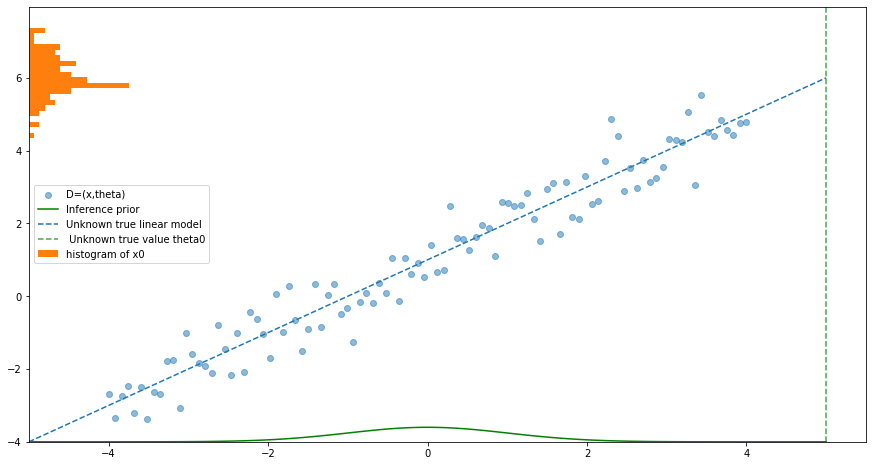

In [76]:
plt.figure(figsize = (15,8))
y_min = -4
plt.scatter(D_theta[:,0].numpy(), D_x.numpy(), alpha =.5, label = 'D=(x,theta)') 
tt = torch.linspace(-5,5,100)
plt.plot(tt, y_min + torch.exp(prior_distribution.log_prob(tt.unsqueeze(-1))), color = 'green', label='Inference prior')
plt.plot(tt.numpy(),f(tt.unsqueeze(-1)).numpy(), linestyle = '--', label = 'Unknown true linear model')
plt.axvline(theta_0.numpy(), color = 'green', alpha = .7, linestyle = '--', label=' Unknown true value theta0')
hist = plt.hist(x0.numpy(), orientation ='horizontal', bins = 20, density = True, bottom = -5, label = 'histogram of x0')
plt.ylim(y_min,)
plt.legend()

In [77]:
def plot_models(models):
    if models.shape[-1]<=2:
        plt.figure()
        tt = torch.linspace(-5,5,100)
        theta_tt = torch.cat([tt.unsqueeze(-1), torch.ones(tt.shape[0]).unsqueeze(-1)], dim = -1)
        x_tt = models@theta_tt.T
        for i in range(models.shape[0]):
            plt.plot(tt, x_tt[i], color = 'black' )
    plt.figure()
    plt.scatter(models[:,-1].numpy(), models[:,-2].numpy())
    plt.show()
    
def plot_2d_function(f, x_min = -10,x_max = 10, y_min = -10, y_max = 10, delta = 200, levels = 2 , alpha = 0.7, new_figure = True):
    if new_figure :
        plt.figure(figsize = (10,10))
        plt.tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
    tt_x = torch.linspace(x_min, x_max, delta)
    tt_y = torch.linspace(y_min,y_max, delta)
    mesh = torch.cartesian_prod(tt_x, tt_y)
    with torch.no_grad():
        plt.contourf(tt_x,tt_y,f(mesh).numpy().reshape(delta,delta).T, levels = levels, cmap = matplotlib.cm.get_cmap('viridis'), alpha = alpha)

In [78]:
class bayesian_linear_regression:
    def __init__(self, x_samples, theta_samples, x0, sigma_simulateur, mu_theta, sigma_theta): 
        self.x_samples = x_samples
        self.theta_samples = theta_samples
        self.num_samples = x_samples.shape[0]
        self.d = theta_samples.shape[-1]
        
        self.sigma_simulateur = sigma_simulateur
        self.mu_theta = mu_theta
        self.sigma_theta = sigma_theta 
        
        self.mu_phi = torch.zeros(self.d+1)
        self.sigma_phi = torch.eye(self.d+1)

        self.mu_phi_D, self.sigma_phi_D = self.compute_parameter_posterior_parameter()
        self.parameter_posterior_distribution = torch.distributions.MultivariateNormal(self.mu_phi_D, self.sigma_phi_D)
        self.x0=x0
    
    def compute_parameter_likelihood(self, D_theta, D_x):
        assert D_theta.shape[0]>=2,'Must have more than 1 dataset sample'
        assert D_theta.shape[0]==D_x.shape[0], 'Mismatch in number samples'
        temp = torch.cat([D_theta, torch.ones(D_theta.shape[0]).unsqueeze(-1)], dim = -1)
        sigma_d_phi = torch.inverse(temp.T@temp)*self.sigma_simulateur**2
        mu_d_phi = D_x@temp@torch.inverse(temp.T@temp)
        return mu_d_phi,sigma_d_phi 

    def dataset_likelihood(self, beta): 
        assert self.num_samples>=1,'No dataset'
        temp = torch.cat([self.theta_samples, torch.ones(self.theta_samples.shape[0]).unsqueeze(-1)], dim = -1)
        mean = beta@temp.T
        sigma = (self.sigma_simulateur**2)*torch.eye(self.d).unsqueeze(0).repeat(self.theta_samples.shape[0],1,1)
        return torch.distributions.MultivariateNormal(mean.unsqueeze(-1),sigma).log_prob(self.x_samples.unsqueeze(-1))
        
    def compute_parameter_posterior_parameter(self, D_theta= None, D_x = None):
        if D_theta is None:
            D_theta = self.theta_samples
        if D_x == None: 
            D_x = self.x_samples
        assert D_theta.shape[0] == D_x.shape[0],'Mismatch in number samples'
        if D_theta.shape[0]>=1:
            temp = torch.cat([D_theta, torch.ones(D_theta.shape[0]).unsqueeze(-1)], dim = -1)
            sigma_phi_d = torch.inverse(temp.T@temp/self.sigma_simulateur**2 + torch.inverse(self.sigma_phi))
            mu_phi_d = sigma_phi_d@(D_x@temp/self.sigma_simulateur**2+ torch.inverse(self.sigma_phi)@self.mu_phi)
        else:
            mu_phi_d, sigma_phi_d = self.mu_phi, self.sigma_phi 
        return mu_phi_d,sigma_phi_d
        

    def log_joint_distribution(self, theta, phi):
        log_prior = torch.distributions.MultivariateNormal(self.mu_theta, self.sigma_theta).log_prob(theta)
        augmented_theta = torch.cat([theta, torch.ones(theta.shape[0],1)], dim = -1)
        temp = torch.bmm(phi.unsqueeze(-2),augmented_theta.unsqueeze(-1)).squeeze(-1)
        temp = temp.repeat(1,self.x0.shape[0])
        cov_matrix = sigma_simulateur * torch.eye(self.x0.shape[0]).unsqueeze(0).repeat(theta.shape[0],1,1)
        log_likelihood = torch.distributions.MultivariateNormal(temp, cov_matrix).log_prob(self.x0) if self.x0.shape[0]>=1 else torch.zeros(theta.shape[0])
        log_parameter_posterior = self.parameter_posterior_distribution.log_prob(phi)
        return log_parameter_posterior+log_prior+log_likelihood
    
    def marginal_log_likelihood_parameters(self, x, theta): 
        mu_phi_d, sigma_phi_d = self.compute_parameter_posterior_parameter()
        gamma = torch.cat([theta, torch.ones(theta.shape[0],1)], dim = -1).unsqueeze(1).repeat(1,x.shape[0],1)
        mean = gamma@mu_phi_d
        cov = gamma@sigma_phi_d.unsqueeze(0).repeat(theta.shape[0],1,1)@torch.transpose(gamma, -2,-1) + self.sigma_simulateur*torch.eye(x.shape[0]).unsqueeze(0).repeat(theta.shape[0],1,1)
        return mean, cov
    
    def marginal_log_likelihood(self, x, theta):
        mean, cov = self.marginal_log_likelihood_parameters(x, theta)
        return torch.distributions.MultivariateNormal(mean, cov).log_prob(x)
    
    def sample_marginal_likelihood(self, num_samples, theta):
        mean, cov = self.marginal_log_likelihood_parameters(torch.zeros(num_samples), theta)
        return torch.distributions.MultivariateNormal(mean, cov).sample()
    
    def compute_posterior_distribution_parameters(self,beta):
        sigma_theta_x0_phi = torch.inverse(torch.inverse(self.sigma_theta) + (self.x0.shape[0]*beta[0]**2)/self.sigma_simulateur**2)
        mu_theta_x0_phi = sigma_theta_x0_phi@(torch.inverse(self.sigma_theta)@self.mu_theta + beta[0]*torch.sum(self.x0 - beta[1])/self.sigma_simulateur**2)
        return mu_theta_x0_phi, sigma_theta_x0_phi 

Sample joint with Gibbs sampling

In [79]:
blr = bayesian_linear_regression(D_x, D_theta, x0, sigma_simulateur, mu_theta, sigma_theta)
current_phi = blr.parameter_posterior_distribution.sample()
mu_theta_x0_phi, sigma_theta_x0_phi = blr.compute_posterior_distribution_parameters(current_phi)
current_theta = torch.distributions.MultivariateNormal(mu_theta_x0_phi, sigma_theta_x0_phi).sample()
list_theta = []
list_phi = []
for t in tqdm(range(10000)):
    current_Theta = current_theta.unsqueeze(0).repeat(x0.shape[0],1)
    D_theta_plus = torch.cat([D_theta, current_Theta], dim = 0)
    D_x_plus = torch.cat([D_x, x0], dim = 0)
    mu_phi_D_plus, sigma_phi_D_plus = blr.compute_parameter_posterior_parameter(D_theta_plus, D_x_plus)
    current_phi = torch.distributions.MultivariateNormal(mu_phi_D_plus, sigma_phi_D_plus).sample()
    mu_theta_x0_phi, sigma_theta_x0_phi = blr.compute_posterior_distribution_parameters(current_phi)
    current_theta = torch.distributions.MultivariateNormal(mu_theta_x0_phi, sigma_theta_x0_phi).sample()
    list_theta.append(current_theta)
    list_phi.append(current_phi)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1280.86it/s]


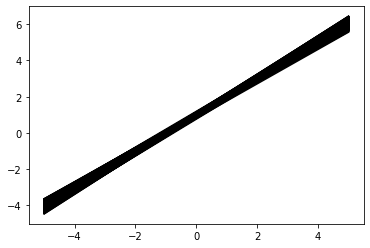

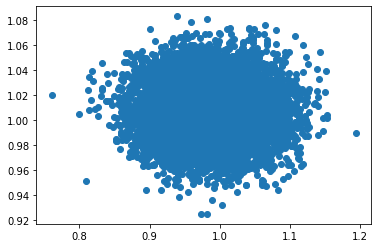

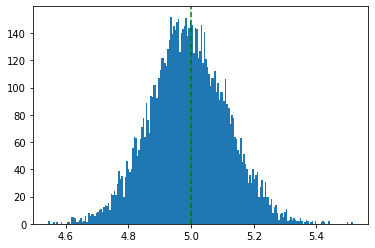

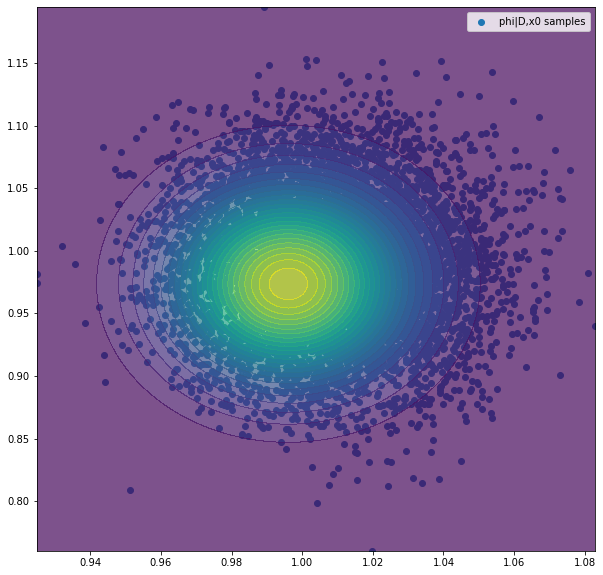

In [80]:
models_phi = torch.stack(list_phi[1000:], dim=0)
plot_models(models_phi)
hist=plt.hist(torch.cat(list_theta[1000:], dim = 0).numpy(), bins= 200)
plt.axvline(theta_0.numpy(), color = 'green', linestyle = '--')
plt.show()

fig = plt.figure(figsize = (10,10))
plt.scatter(models_phi[:,0].numpy(), models_phi[:,1].numpy(), label = 'phi|D,x0 samples')
plot_2d_function(lambda samples:torch.exp(blr.parameter_posterior_distribution.log_prob(samples)),x_min = torch.min(models_phi[:,0]), x_max = torch.max(models_phi[:,0]),y_min = torch.min(models_phi[:,1]), y_max = torch.max(models_phi[:,1]),levels = 25, new_figure = False)
plt.legend()

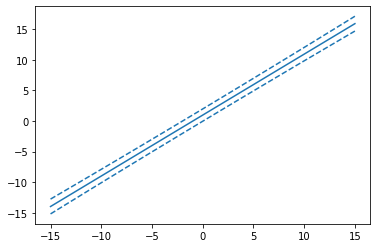

In [81]:
tt = torch.linspace(-15,15,100)
mean, cov =  blr.marginal_log_likelihood_parameters(torch.zeros(1), tt.unsqueeze(-1))
plt.plot(tt, mean)
plt.plot(tt,mean.squeeze(-1) + 2*cov.squeeze(-1).squeeze(-1), color = 'C0', linestyle = '--')
plt.plot(tt,mean.squeeze(-1) - 2*cov.squeeze(-1).squeeze(-1), color = 'C0', linestyle= '--')
sample = blr.sample_marginal_likelihood(10,tt.unsqueeze(-1))

In [82]:
#Sampling the posterior p(phi|D) with weighted likelihood bootstrap

number_chains = 1000
beta= torch.randn(number_chains,d+1)
beta.requires_grad_()
w = torch.distributions.dirichlet.Dirichlet(torch.ones(n_D)).sample([number_chains])
epochs = 2000
optimizer = torch.optim.Adam([beta], lr = 5e-2)
pbar = tqdm(range(epochs))
for i in pbar:
    optimizer.zero_grad()
    loss = - torch.mean(torch.sum(blr.dataset_likelihood(beta)*w, dim = 1), dim=0)
    loss.backward()
    optimizer.step()
    pbar.set_postfix_str(str(loss.item()))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:16<00:00, 119.86it/s, 0.8707383871078491]


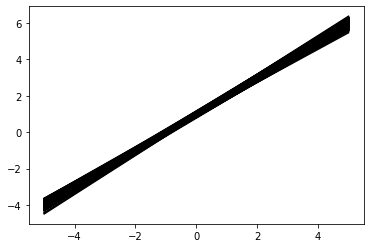

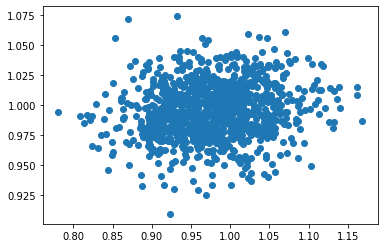

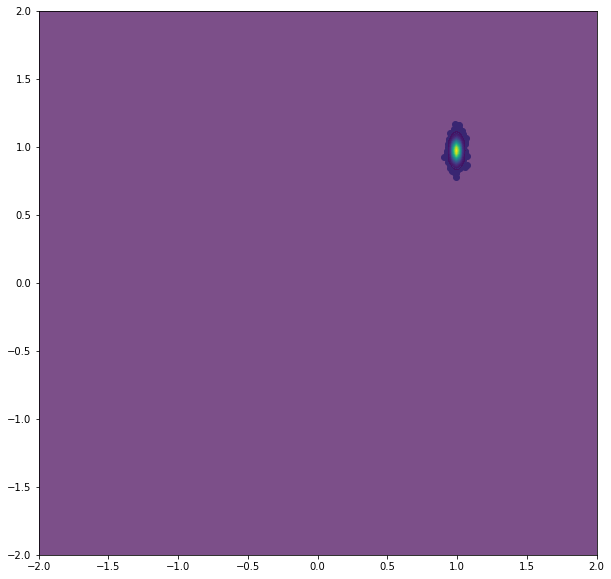

In [83]:
plot_models(beta.detach())
fig = plt.figure(figsize = (10,10))
plt.scatter(beta[:,0].detach().numpy(), beta[:,1].detach().numpy())
plot_2d_function(lambda samples:torch.exp(blr.parameter_posterior_distribution.log_prob(samples)),x_min = torch.min(beta[:,0]), x_max = 2,y_min = -2, y_max = 2,levels = 50, new_figure = False)